In [13]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, TimestampType, StringType
from pyspark.sql.window import Window
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib

# spark initialization
spark = SparkSession.builder.appName("gamedata").getOrCreate()
hard_weekly_df = spark.read.parquet("../database/parquet/hard_weekly")

In [14]:
hard_weekly_df

DataFrame[begin_date: date, end_date: date, hw: string, units: int]

## PlayStation World年単位の集計

年単位集計を行うために､yearカラムを追加｡値は end_dateを F.year()で変換する｡
なお､1998年のデータは年末だけなので､1999年以後でフィルタする｡

In [15]:
hard_weekly_year_df = hard_weekly_df.withColumn("year", F.year(F.col("end_date"))).filter(F.col("year") > 1998).filter(F.col("year") < 2023)

## グループ化して集計

年(year)ごと､ハード(hw)ごとにグループ化して集計する

In [16]:
hard_yearly_df = hard_weekly_year_df.groupBy("year", "hw").agg(
    F.sum(F.col("units")).alias("units")).sort("year")

In [17]:
# hard_yearly_df = hard_weekly_year_df.groupBy("year", "hw").sum("units").sort("year")
# aliasが通らないので面倒かも

## pivot化

pivotを使ってHW名を列に並べる｡縦軸は年｡値はunitsをそのまま用いる｡

縦軸にしたいカラムでgroupBy()して､横軸をpivot()に指定する｡
HWの表示順を調整するためにselectしておく

In [18]:
hard_yearly_pivot = hard_yearly_df.groupBy("year").pivot("hw").sum("units").sort("year").select(
    "year",
    "PS5", "PS4", "Vita", "PS3", "PSP", "PS2")


In [19]:
hard_yearly_pivot.show(30)

+----+-------+-------+-------+-------+-------+-------+
|year|    PS5|    PS4|   Vita|    PS3|    PSP|    PS2|
+----+-------+-------+-------+-------+-------+-------+
|1999|   null|   null|   null|   null|   null|   null|
|2000|   null|   null|   null|   null|   null|3100793|
|2001|   null|   null|   null|   null|   null|3279043|
|2002|   null|   null|   null|   null|   null|3719575|
|2003|   null|   null|   null|   null|   null|2990421|
|2004|   null|   null|   null|   null| 349283|2759422|
|2005|   null|   null|   null|   null|2194005|2102273|
|2006|   null|   null|   null| 466715|1969360|1554467|
|2007|   null|   null|   null|1216482|3038309| 818771|
|2008|   null|   null|   null| 991255|3552104| 480804|
|2009|   null|   null|   null|1723034|2305627| 253616|
|2010|   null|   null|   null|1500658|2704975|  89572|
|2011|   null|   null| 402794|1414743|1889805|  56235|
|2012|   null|   null| 680893|1332547| 951494|  26201|
|2013|   null|   null|1191450| 818803| 419888|   4689|
|2014|   n

## pandas変換

pandasのplotでグラフ化するためpandasのDFに変換する｡

デフォルトだとindexが連番になるので､yearがindexになるようpandas側で調整する｡

In [20]:
hw_year = hard_yearly_pivot.toPandas().set_index("year")

## グラフ化

面グラフを作成する

<Axes: xlabel='年', ylabel='年間販売台数'>

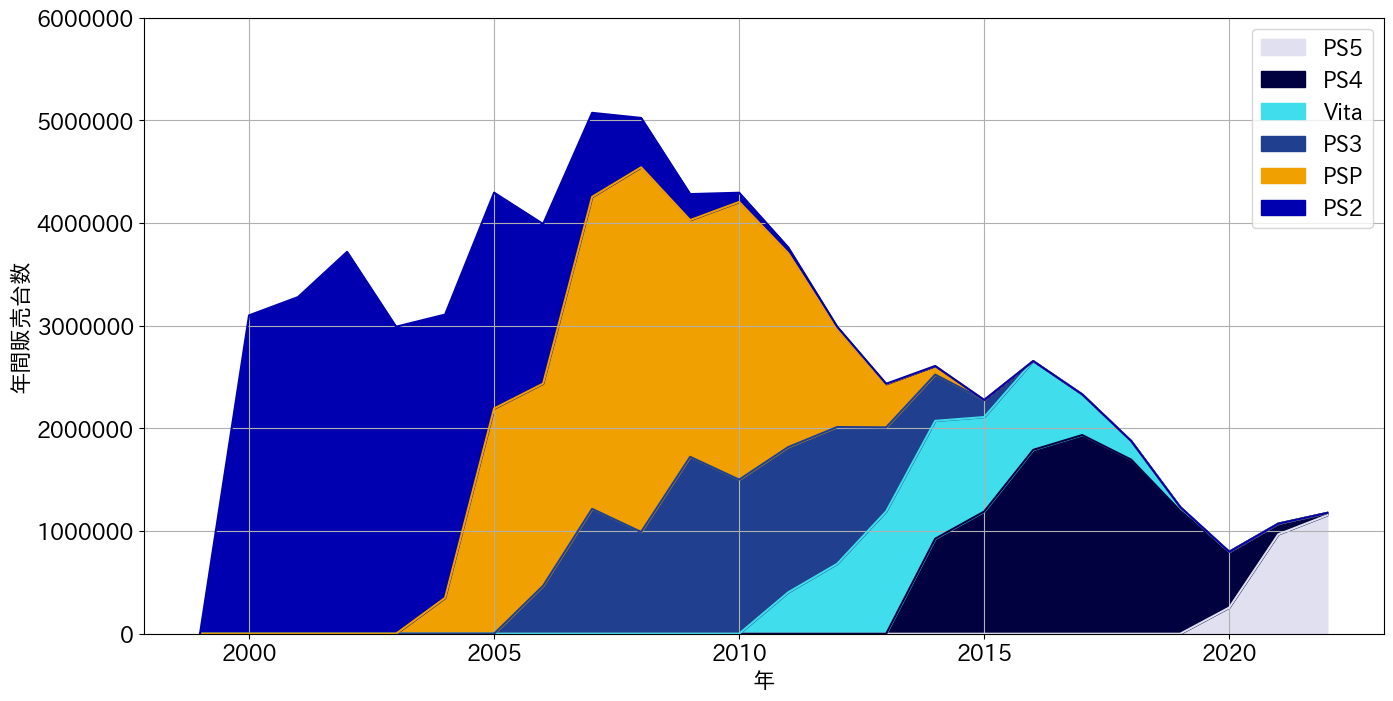

In [21]:
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots()
ax.set_ylabel("年間販売台数")
#|ax.set_xticks([2000,2005,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])
ax.ticklabel_format(style='plain')
hw_year.plot(figsize=(16,8), ax=ax, 
             grid=True, kind="area", ylim=[0, 6000000], xlabel="年",
             color=('#e0e0f0','#010140', '#40deec', 
                    '#20408f', '#f0a000', '#0000b0'),
            )

In [22]:
cs_yearly_pivot = hard_yearly_df.groupBy("year").pivot("hw").sum("units").sort("year").select(
    "year",
    "PS5", "PS4", "PS3", "PS2")


In [23]:
cs_year = cs_yearly_pivot.toPandas().set_index("year")

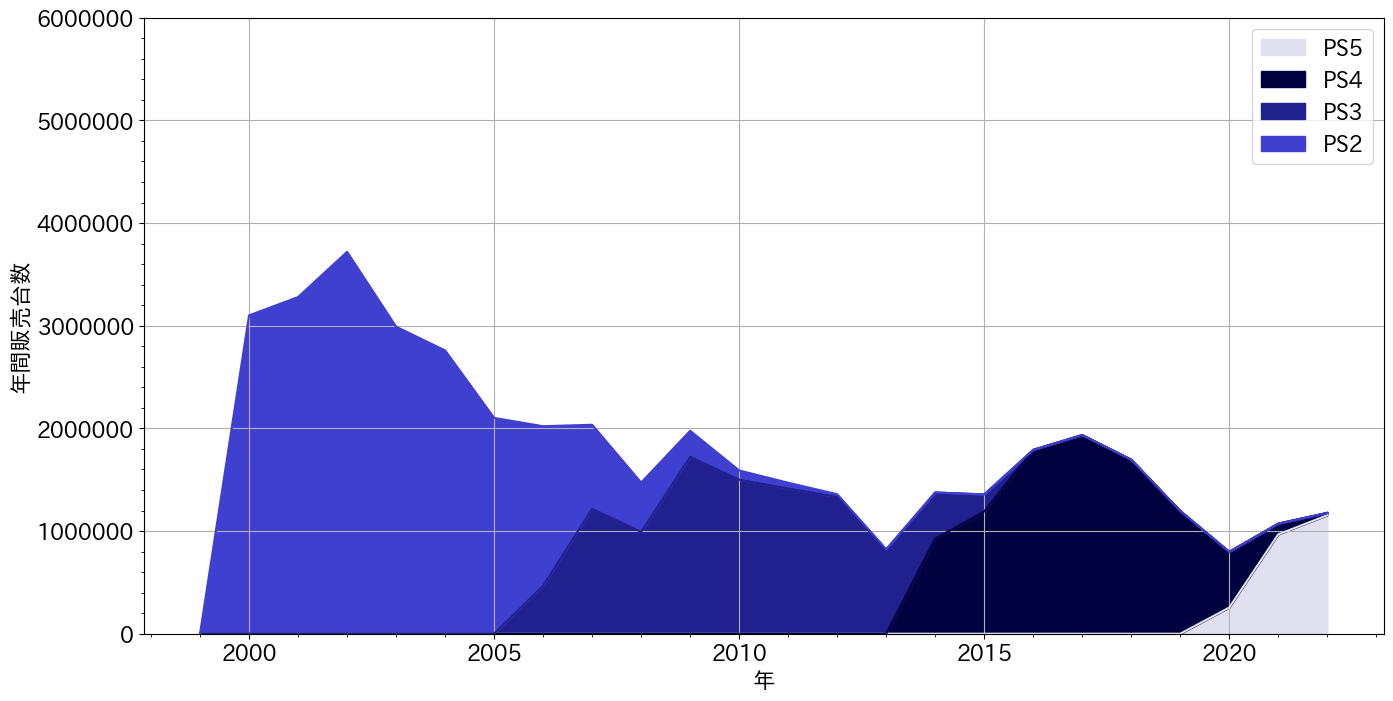

23/06/30 03:45:20 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 771862 ms exceeds timeout 120000 ms
23/06/30 03:45:21 WARN SparkContext: Killing executors is not supported by current scheduler.
23/06/30 03:45:28 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [24]:
fig, bx = plt.subplots()
bx.set_ylabel("年間販売台数")
bx.ticklabel_format(style='plain')
cs_year.plot(ax=bx, figsize=(16,8), xlabel="年", grid=True, kind="area", ylim=[0, 6000000], color=('#e0e0f0', '#010140', '#20208f', '#4040d0')).minorticks_on()